In [356]:
# Imports
import numpy as np
import random # todo - replace with custom implementation
rdm = random.random


In [586]:
# Probability Parameters
p_decelerate = .10 # prob. car decelerates
p_change     = .50 # prob. car changes lanes
p_exit       = .05 # prob. car turns off corridor
p_enter      = .05  # prob. car turns onto corridor
p_left       = .50 # prob. car chooses left lane to swap if both are available
p_fill       = .5  # prob. that road section starts with car
p_add_car    = .7  # prob. that car is added to corridor each time step

In [578]:
# Parameters
LENGTH        = 200
LANES         = 3
INTERSECTIONS = 1
TIME_STEPS    = 1000
MOD           = 10 # light is red every MOD step

# Internal use only
data_type = np.int64
data_size = 3

In [605]:
# By defining the following two functions, we can model different speed 
# distributions later
def get_max_v(): 
    return 5 

def get_starting_v(): 
    return 3

# For now, we will assume the corridors are equally spaced. Later, 
# we can spread them out to match reality
def get_intersections(num, corridor_length):
    a = dict()
    for i in range(num):
        i = (i+1) * (corridor_length / (num+1))
        i = np.int64(i)
        a[i] = dict()
        a[i]['state'] = 'green'
    a = initialize_lights(a)
    return a
        
# Fill spaces in corridor with cars with probability p_fill
def initialize_corridor(length, lanes, data_size, p_fill):
    corridor_shape = (length, lanes, data_size)
    new = np.zeros(corridor_shape, dtype=data_type)
    (length, lanes, _) = new.shape
    for i in range(length):
        for j in range(lanes):
            if rdm() >= p_fill:
                continue
            new[i,j,0] = get_starting_v()
            new[i,j,1] = get_max_v()
            
    return new

# Draw from some probability distribution - uniform for now - and 
# return cars (or zeros)
# p1 and p2 are the distribution parameters
# give the car a unique identifier
def get_car(dist, p1=.1, p2=0, cid = -1):
    if dist == "UNIFORM":
        if rdm() < p1:
            v = get_starting_v()
            max_v = get_max_v()
            if cid == -1:
                car_id = np.random.randint(low=0, high=2000000000)
            else:
                car_id = cid
            return (v, max_v, car_id)
        
    return (0,0,0)

def initialize_lights(intersections):
    return intersections
                     

In [610]:
# This function sees if the cars want to changes lanes, then moves them

def step_lanechange(cur, INT, data, t):
    (length, lanes, _) = cur.shape
    new = np.zeros(cur.shape, dtype=data_type)
    if lanes < 2:
        return cur
    
    for j in range(lanes):
        pred = length + 2*max_v
        for i in range(length):
            
            v = cur[i,j,0]   # current speed
            v_d = cur[i,j,1] # max speed
            
            if v_d == 0:
                #check to see if car enters intersection
                if (i in INT.keys()) and (j == 0 or j == lanes-1) and (rdm() < p_enter):
                    car = get_car("UNIFORM", p_add_car, cid=0)
                    cur[i,j,:] = car
                    new[i,j,:] = car
                continue
                        
            l = v+1
            l_o = l
            l_o_back = max_v
            
            gap = 0
            gap_r = 0
            gap_r_back = 0
            gap_l = 0
            gap_l_back = 0
            occ_l = True
            occ_r = True
            
            # Check to see if car exits at intersection
            if (i in INT.keys()) and (j == 0 or j == lanes-1) and (rdm() < p_exit):
                #simply continue to delete car
                continue
                
            # Check to see if car enters at intersection
            
            
            #T1
            for ii in range(i+1,length):
                if cur[ii,j,1] == 0:
                    gap = gap + 1
                else:
                    break
            
            if j != 0:
                #T2
                for ii in range(i+1,length):
                    if cur[ii,j-1,1] == 0:
                        gap_l = gap_l + 1
                    else:
                        break
                
                #T3
                for ii in range(i-1, -1,-1):
                    if cur[ii,j-1,1] == 0:
                        gap_l_back = gap_l_back + 1
                    else:
                        break
                    
                #Check other lane not occupied
                if cur[i,j-1,1] == 0:
                    occ_l = False
                        
            if j != lanes-1:
                #T2
                for ii in range(i+1,length):
                    if cur[ii,j+1,1] == 0:
                        gap_r = gap_r + 1
                    else:
                        break
                
                #T3
                for ii in range(i-1, -1,-1):
                    if cur[ii,j+1,1] == 0:
                        gap_r_back = gap_r_back + 1
                    else:
                        break
                #Check other lane not occupied
                if cur[i,j+1,1] == 0:
                    occ_r = False
                
            
            if i + gap == length-1:
                gap = 1000000000
            if i + gap_l == length-1: 
                gap_l = 1000000000
            if i + gap_r == length-1: 
                gap_r = 1000000000
            if i - gap_l_back == 0: 
                gap_l_back = 1000000000
            if i - gap_r_back == 0: 
                gap_r_back = 1000000000
                

            can_move_left = (gap < l and gap_l > l_o and gap_l_back > l_o_back and not occ_l)
            can_move_right = (gap < l and gap_r > l_o and gap_r_back > l_o_back and not occ_r)

            #T4
            if rdm() < p_change:
                if rdm() < p_left: #check left side first
                    if can_move_left:
                        new[i,j-1,:] = cur[i,j,:]
                        continue
                    if can_move_right:
                        new[i,j+1,:] = cur[i,j,:]
                        continue
                else:                  #look right first
                    if can_move_right:
                        new[i,j+1,:] = cur[i,j,:]
                        continue
                    if can_move_left:
                        new[i,j-1,:] = cur[i,j,:]
                        continue
            new[i,j,:] = cur[i,j,:]
    
    return new

In [612]:
def step_movement(cur, INT, data, t):
    (length, lanes, _) = cur.shape
    new = np.zeros(cur.shape, dtype=data_type)
    
  
    
    for j in range(lanes):
        pred = length + 2*max_v #position of last observed car
        prev_light = -1 # last seen traffic light
        for i in range(length-1,-1,-1):
                        
            v = cur[i,j,0].astype(data_type)      # current speed
            v_d = cur[i,j,1]    # max speed
            car_id = cur[i,j,2] #car id
            
            if v_d == 0:     # if max speed == 0, this cell is empty
                continue
            
            gap = pred - i - 1
            if v < v_d:
                v = v + 1               #S1
            if v > gap: 
                v = gap                 #S2
            if v > 0 and rdm() < p_decelerate:
                v = v - 1               #S3
                
            # check traffic lights
            if prev_light != -1:
                if lights[prev_light]['state'] == 'red':
                    gap_light = prev_light - i - 1
                    if v > gap_light:
                        v = gap_light   #S4
                

            if i + v < length:
                new[i+v,j,0] = v
                new[i+v,j,1] = v_d
                new[i+v,j,2] = car_id
            else:
                #car exits corridor
                if car_id != 0:
                    data[car_id]['finish'] = t
                
            pred = i
            if i in INT:
                prev_light = i
            
    return new
             

In [580]:
def step_lights(lights, t, MOD):
    if t % MOD == 0:
        for k in lights.keys():
            lights[k]['state'] = 'red'
    else:
        for k in lights.keys():
            lights[k]['state'] = 'green'
            
    return lights


In [554]:
def add_cars(state, t):
    lanes = state.shape[1]
    for j in range(lanes):
        if state[0,j,1] == 0:
            car = get_car("UNIFORM", p_add_car)
            if car[2] != 0:
                car_id = car[2]
                if car_id in data.keys():
                    print('key collision')
                    continue
                data[car_id] = dict()
                data[car_id]['start'] = t
                
            state[0,j,:] = car
    return state

In [589]:
def calculate_deltas(data):
    deltas = []
    for k in data.keys():
        if 'finish' in data[k].keys():
            #print("delta: %s, %s" % (data[k]['finish'], data[k]['start']))
            deltas.append(data[k]['finish']- data[k]['start'])
            
    return np.asarray(deltas)

In [613]:
########################
# Main simulation code #
########################

state  = initialize_corridor(LENGTH, LANES, data_size, p_fill)
lights = get_intersections(INTERSECTIONS, LENGTH)
data   = dict()

for t in range(TIME_STEPS):

    # Update state 
    state  = step_lanechange(state, lights, data, t)
    state  = step_movement(state, lights, data, t)
    lights = step_lights(lights, t, MOD)
    state  = add_cars(state, t)



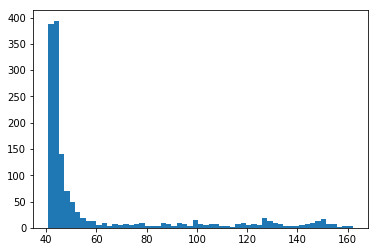

In [614]:
# Preliminary Data Viz
deltas = calculate_deltas(data)
import matplotlib.pyplot as plt
plt.hist(deltas, bins='auto')
plt.show()